In [5]:
from qutip import *

import numpy as np

import matplotlib.pyplot as plt

(CVXPY) Jan 17 01:51:47 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [6]:
def Hxyz(N, Jx, Jy, Jz, b, periodic=False):
    """Generates an XYZ spin chain Hamiltonian with N spins"""
    J_list = [Jx, Jy, Jz]
    sigma_list = [sigmax(), sigmay(), sigmaz()]
    if N <= 1:
        return qeye(2**N)
    Ham = 0
    for i in range(N-1):
        for j in range(3):
            spin_list = [sigma_list[j] if k == i or k == i+1 else qeye(2) for k in range(N)]
            Ham += J_list[j]*tensor(spin_list)
    for i in range(N):
        spin_list = [sigmaz() if k == i else qeye(2) for k in range(N)]
        Ham += b*tensor(spin_list)
    if periodic:
        for j in range(3):
            spin_list = [sigma_list[j] if k == 0 or k == N-1 else qeye(2) for k in range(N)]
            Ham += J_list[j]*tensor(spin_list)
    return Ham

In [104]:
#set all the relevant parameters
bfield = 0.5
J = 1.
gamma = 1.
Delta = 0.

num_collision = 400
collision_duration = 0.5
timestep = 0.01

num_spins = 4

In [105]:
#generate initial states
psi_0 = tensor([rand_ket_haar(2) for _ in range(num_spins)])
rho_S_0 = psi_0 * psi_0.dag()
rho_A = basis(2,0) * basis(2,0).dag()

#expectation values to calculate
expec_list_S = [tensor([sigmax() if k == i else qeye(2) for k in range(num_spins)]) 
              for i in range(num_spins)]
expec_list_SA = [tensor([sigmax() if k == i else qeye(2) for k in range(num_spins )] + [qeye(2)]) 
              for i in range(num_spins)]

#system and interaction Hamiltonians
H_S = -Hxyz(num_spins, J, J*gamma, J*Delta, bfield, periodic=True)
H_SA = 0.5*(tensor(sigmax(), *[qeye(2) for _ in range(num_spins - 1)], sigmax()) 
          + tensor(sigmay(), *[qeye(2) for _ in range(num_spins - 1)], sigmay()))

In [106]:
def collision_model_dynamics(num_spins, num_col, rho_S_0, rho_A, expec_list_S, H_S, H_int, t, gamma, dt):
    """Simulates collision model dynamics and returns expectation values at each step"""
    state = tensor(rho_S_0, rho_A)
    expec_list_SA = [tensor(ex, qeye(2)) for ex in expec_list_S]
    H_col = tensor(H_S, qeye(2)) + H_int
    free_steps = np.ceil(np.random.exponential(gamma/dt, size = num_col))
    col_step = int(np.ceil(t/dt))
    total_col = np.sum(free_steps) + col_step*num_col
    num_expec = len(expec_list_S)
    expec_out = np.zeros((int(total_col), num_expec))
    #expec_out = []
    times_col = np.linspace(dt, col_step*dt, col_step)
    expec_loc = 0
    trace_list = [i for i in range(num_spins)]
    opts = Options()
    opts.store_final_state = True
    


    for i in range(num_col):
        res_col = mesolve(H_col, state, times_col, [], expec_list_SA, options = opts)
        for j in range(col_step):
            for k in range(num_expec):
                expec_out[expec_loc][k] = res_col.expect[k][j]
            expec_loc += 1
        
        times_free = np.linspace(dt, free_steps[i]*dt, int(free_steps[i]))
        rho_S = res_col.final_state.ptrace(trace_list)
        res_free = mesolve(H_S, rho_S, times_free, [], expec_list_S, options = opts)
        for j in range(int(free_steps[i])):
            for k in range(num_expec):
                expec_out[expec_loc][k] = res_free.expect[k][j]
            expec_loc += 1
        
        state = tensor(res_free.final_state, rho_A)
    
    return expec_out

In [107]:
expectations = collision_model_dynamics(num_spins, num_collision, rho_S_0, rho_A, expec_list_S, 
                               H_S, H_SA, collision_duration, gamma, timestep)

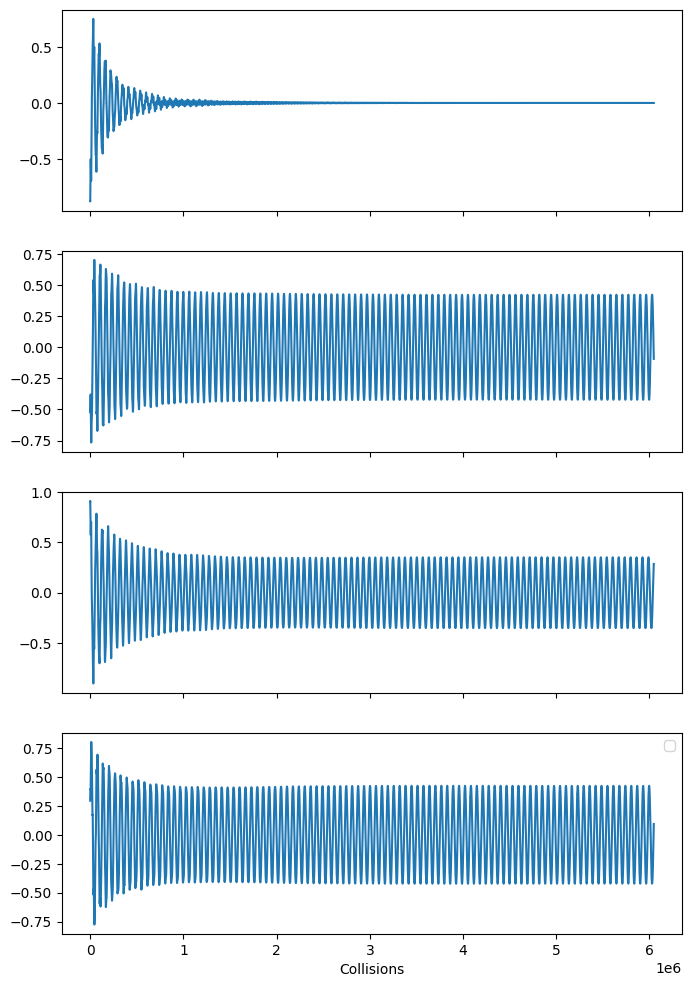

In [108]:
time_axis = np.arange(expectations.shape[0]) * 100

fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)

axs[0].plot(time_axis, expectations[:, 0])
axs[1].plot(time_axis, expectations[:, 1])
axs[2].plot(time_axis, expectations[:, 2])
axs[3].plot(time_axis, expectations[:, 3])

axs[3].set_ylabel('Expec')
axs[3].set_xlabel('Collisions')

plt.xlabel('Collisions')
plt.ylabel('')
plt.legend()

plt.show()